In [1]:
%matplotlib inline
import pandas as pd
import numpy as np


In [2]:
data = pd.read_csv('ratings.csv')
#cast to int so IDS can be used as indices
data = data.astype(int)

In [3]:
#encoding Movie Ids as indices from 0 -> # of unique movies)))
encode, decode = {}, {}
for i, x in enumerate(data['movieId'].unique()):
    encode[x] = i
    decode[i] = x
    
data['movieId'] = data['movieId'].apply(lambda x: encode[x])



In [4]:
ratings = data.pivot(index='userId', columns='movieId', values='rating')
ratings.head()

movieId,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,4.0,5.0,5.0,3.0,5.0,4.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:

samples = data[['userId', 'movieId', 'rating']].copy()
#subtract one to map userId to proper indices 
samples['userId'] = samples['userId'] - 1
samples = samples.values
#preview the samples array. userId, movieId, rating
samples

array([[   0,    0,    4],
       [   0,    1,    4],
       [   0,    2,    4],
       ...,
       [ 609, 3121,    5],
       [ 609, 1392,    5],
       [ 609, 2873,    3]])

In [6]:
#rsme calculator
def rmse(dset, preds):
    rmse = 0 
    for i, j, rating in dset:
        rmse += np.power((rating - preds[i, j]), 2)
    return np.sqrt(1/len(dset) * rmse)
    

In [7]:
#shuffling dataset
np.random.shuffle(samples)

In [11]:
len_users, len_movies = ratings.shape
K = 1

#this is the best LR i've found so far
lr = .01
#arbitrarily chosen
lmb = .5
#might change epochs later depending on learning rate
epochs = 30

U = np.random.normal(scale=1./K, size=(len_users, K))
V = np.random.normal(scale=1./K, size=(len_movies, K))

train = samples[:80000]
test = samples[90000:]
error = []
for iteration in range(1, epochs):
    #shuffles train set before running SGD
    np.random.shuffle(train)
    for i, j, rating in train:
        pred = U[i,:] * V[j,:]
        err = (rating - pred)

        U[i, :] += lr * (err * V[j, :] - (lmb * U[i, :]))
        V[j, :] += lr * (err * U[i, :] - (lmb * V[j, :]))
    
    res = U @ V.T
    
    rmse_train = rmse(train, res)
    rmse_test = rmse(test, res)
    if iteration % 10 == 0:
        print('iteration', iteration, '\nrsme for train\n', rmse_train, 
               '\nrsme for test\n', rmse_test)
    error += [(rmse_train, rmse_test)]

    

    

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-240732b95ee4>", line 21, in <module>
    pred = U[i,:] * V[j,:]
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1095, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/lib/python3.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*

KeyboardInterrupt: 

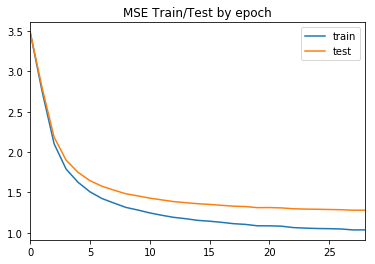

In [9]:
lr = .01
#arbitrarily chosen
lmb = float(1)
#num of epochs
epochs = 30
#best K i've found
K = 1
def train_model(lr, lmb, K, epochs):
    '''lr = learning rate
       lmb = regularization parameter
       K = number of latent dimensions
       epochs = #numer of times to run SGD'''
    len_users, len_movies = ratings.shape
    U = np.random.normal(scale=1./K, size=(len_users, K))
    V = np.random.normal(scale=1./K, size=(len_movies, K))

    train = samples[:80000]
    test = samples[90000:]
    error = []
    for iteration in range(1, epochs):
        #shuffles train set before running SGD
        np.random.shuffle(train)
        for i, j, rating in train:
            pred = U[i,:] * V[j,:]
            err = (rating - pred)

            U[i, :] += lr * (err * V[j, :] - (lmb * U[i, :]))
            V[j, :] += lr * (err * U[i, :] - (lmb * V[j, :]))

        res = U @ V.T

        rmse_train = rmse(train, res)
        rmse_test = rmse(test, res)
        if iteration % 10 == 0:
            print('iteration', iteration, '\nrsme for train\n', rmse_train, 
                   '\nrsme for test\n', rmse_test)
        error += [(rmse_train, rmse_test)]
    return error

training_error = train_model(lr, lmb, K, epochs)

#plotting
pd.DataFrame(data=training_error, columns=['train', 'test']).plot(title='MSE Train/Test by epoch')

KeyboardInterrupt: 

In [16]:

results = {}
for reg in [10**-6, 10**-3, .1, .5, 2, 5, 10, 
           20, 50, 100, 500, 1000]:
    
    #iterating through the learning rates 
    print('predicting for', reg)
    results[reg] = train_model(lr, reg, K, epochs)
    
    

{1e-06: [(3.4261436390012237, 3.453877981012616),
  (2.449878470850168, 2.496113838836589),
  (1.8716527397407225, 1.9582746572486145),
  (1.599358237052606, 1.7189665403786207)],
 0.001: [(3.5218778871733947, 3.5576782144542314),
  (3.310691654836186, 3.3617676439598796),
  (2.3164393206677603, 2.388487120137836),
  (1.8186053914984293, 1.9174434541434304)],
 0.1: [(3.4901140826518557, 3.515642103907803),
  (2.6531510566128325, 2.6814999070046355),
  (1.979625325677462, 2.0373722091968216),
  (1.665653846827979, 1.7539293726189678)],
 0.5: [(3.424534312877203, 3.4510422182924034),
  (2.5672293857973645, 2.613661467120805),
  (2.014001326224924, 2.0858651096356087),
  (1.750247627305928, 1.8444843811939207)],
 2: [(3.516911865698048, 3.536723972930567),
  (3.5001717674779353, 3.517867305144681),
  (3.425583965734842, 3.4438071635742555),
  (3.209474528996639, 3.2321601381556113)],
 5: [(3.5224885657567384, 3.537488557611731),
  (3.522799291767486, 3.5371560761435297),
  (3.522958238418